In [ ]:
# UT3-11 (Parcial): Comparativa YOLO y Tracking
# Cobertura: Trabajo 1 (parcial), Trabajo 2 (parcial), Trabajo 3 (parcial)
# Objetivo: rapidez para experimentar, no entrenar todo

# === Instalación rápida ===
!pip install -q ultralytics opencv-python matplotlib numpy pandas seaborn gdown norfair motmetrics

# Detectron2 (opcional, puede requerir CUDA/Colab compatible)
# Si falla en local, deja esta celda comentada o ejecútala en Colab con CUDA 11.8
# !pip install detectron2 -f \
#   https://dl.fbaipublicfiles.com/detectron2/wheels/cu118/torch2.0/index.html

import os, time, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
from ultralytics import YOLO
import ultralytics
print(f"Ultralytics: {ultralytics.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Norfair
from norfair import Detection, Tracker
from norfair.distances import mean_euclidean

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

device_choosen = 0 if torch.cuda.is_available() else 'cpu'
print(f"Device: {device_choosen}")


Ultralytics: 8.3.222
CUDA disponible: True
GPU: Tesla T4
Device: 0


In [ ]:
# === Setup de Dataset (autosuficiente) ===
# Descarga desde Kaggle: lakshaytyagi01/fruit-detection (formato YOLO)

import os, glob, yaml, shutil, subprocess, zipfile
from pathlib import Path

# Instalar Kaggle CLI si no está
try:
    import kaggle  # type: ignore
except Exception:
    subprocess.run(["pip", "install", "-q", "kaggle"], check=False)

# Asegurar kaggle.json en ~/.kaggle (si existe localmente, copiarlo)
home_kaggle = Path.home() / ".kaggle"
home_kaggle.mkdir(parents=True, exist_ok=True)
if Path("kaggle.json").exists() and not (home_kaggle / "kaggle.json").exists():
    shutil.copyfile("kaggle.json", home_kaggle / "kaggle.json")
    try:
        os.chmod(home_kaggle / "kaggle.json", 0o600)
    except Exception:
        pass

print("\n=== DESCARGANDO DATASET DE KAGGLE ===")
DATASET_ZIP = Path('fruit-detection.zip')
DATASET_DIR = Path('fruit_detection')

if not DATASET_DIR.exists():
    # Descargar con Kaggle CLI
    subprocess.run(["kaggle", "datasets", "download", "-d", "lakshaytyagi01/fruit-detection", "-p", ".", "-q"], check=False)
    if DATASET_ZIP.exists():
        DATASET_DIR.mkdir(parents=True, exist_ok=True)
        with zipfile.ZipFile(DATASET_ZIP, 'r') as zf:
            zf.extractall(DATASET_DIR)
        print("✅ Dataset descomprimido en:", DATASET_DIR)
    else:
        print("❌ No se pudo descargar el zip. Asegura kaggle.json en ~/.kaggle o en el directorio actual.")
else:
    print("Dataset ya presente en:", DATASET_DIR)

# Verificar/crear data.yaml
print("\n=== VERIFICANDO/CREANDO data.yaml ===")
yaml_files = list(DATASET_DIR.glob('**/data.yaml'))
if yaml_files:
    YAML_PATH = yaml_files[0]
else:
    # Intentar detectar estructura común
    train_dirs = list(DATASET_DIR.glob('**/train/images')) + list(DATASET_DIR.glob('**/images/train'))
    val_dirs = list(DATASET_DIR.glob('**/valid/images')) + list(DATASET_DIR.glob('**/val/images')) + list(DATASET_DIR.glob('**/images/val'))

    if train_dirs and val_dirs:
        train_path = str(train_dirs[0].relative_to(DATASET_DIR))
        val_path = str(val_dirs[0].relative_to(DATASET_DIR))
    else:
        train_path = 'train/images'
        val_path = 'valid/images'

    # Clases típicas del dataset
    fruit_classes = ['apple', 'banana', 'grapes', 'orange', 'pineapple', 'watermelon']

    data_config = {
        'path': str(DATASET_DIR.absolute()),
        'train': train_path,
        'val': val_path,
        'nc': len(fruit_classes),
        'names': fruit_classes
    }
    YAML_PATH = DATASET_DIR / 'data.yaml'
    with open(YAML_PATH, 'w') as f:
        yaml.dump(data_config, f)
    print("✅ Creado:", YAML_PATH)

# Estadísticas rápidas
def count_images(rel_path: str) -> int:
    return len(list((DATASET_DIR / rel_path).glob("*.jpg"))) + len(list((DATASET_DIR / rel_path).glob("*.png")))

with open(YAML_PATH, 'r') as f:
    cfg = yaml.safe_load(f)

train_rel = cfg['train']
val_rel = cfg['val']

# Si las rutas son absolutas, intentar corregir a relativas bajo DATASET_DIR
def find_split_dir(root: Path, split: str) -> str | None:
    # Busca 'train/images' o 'valid/images' dentro del root
    candidates = list(root.glob(f"**/{split}/images")) + list(root.glob(f"**/images/{'train' if split=='train' else 'val'}"))
    if candidates:
        try:
            return str(candidates[0].relative_to(root))
        except Exception:
            return str(candidates[0])
    return None

def is_abs(p: str) -> bool:
    try:
        return Path(p).is_absolute()
    except Exception:
        return False

# Determinar nuevas rutas si son absolutas o no existen
needs_fix = False
new_train = train_rel
new_val = val_rel
if is_abs(train_rel) or not (DATASET_DIR / train_rel).exists():
    cand = find_split_dir(DATASET_DIR, 'train')
    if cand:
        new_train = cand
        needs_fix = True
if is_abs(val_rel) or not (DATASET_DIR / val_rel).exists():
    cand = find_split_dir(DATASET_DIR, 'valid')
    if cand:
        new_val = cand
        needs_fix = True

# Guardar data_fixed.yaml si fue necesario
if needs_fix:
    data_fixed = dict(cfg)
    data_fixed['path'] = str(DATASET_DIR.absolute())
    data_fixed['train'] = new_train
    data_fixed['val'] = new_val
    YAML_PATH = DATASET_DIR / 'data_fixed.yaml'
    with open(YAML_PATH, 'w') as f:
        yaml.dump(data_fixed, f)
    print("🔧 Rutas absolutas detectadas. Creado data_fixed.yaml con rutas relativas:")
    print("   train:", new_train)
    print("   val:  ", new_val)
else:
    YAML_PATH = YAML_PATH  # mantener

# Conteos robustos (acepta abs/rel)
def count_images_any(p: str) -> int:
    pth = Path(p)
    if pth.is_absolute():
        return len(list(pth.glob('*.jpg'))) + len(list(pth.glob('*.png')))
    else:
        return len(list((DATASET_DIR / p).glob('*.jpg'))) + len(list((DATASET_DIR / p).glob('*.png')))

print(f"\n📁 Train images dir: {new_train}")
print(f"📁 Val images dir:   {new_val}")
print(f"   Train imgs: {count_images_any(new_train)} | Val imgs: {count_images_any(new_val)}")

# Variables globales para el resto del notebook
DATASET_ROOT = DATASET_DIR
print("\n✅ Dataset listo. YAML_PATH =", YAML_PATH)



=== DESCARGANDO DATASET DE KAGGLE ===
Dataset ya presente en: fruit_detection

=== VERIFICANDO/CREANDO data.yaml ===
🔧 Rutas absolutas detectadas. Creado data_fixed.yaml con rutas relativas:
   train: Fruits-detection/train/images
   val:   Fruits-detection/valid/images

📁 Train images dir: Fruits-detection/train/images
📁 Val images dir:   Fruits-detection/valid/images
   Train imgs: 7108 | Val imgs: 914

✅ Dataset listo. YAML_PATH = fruit_detection/data_fixed.yaml


In [ ]:
# === Trabajo 1 (parcial): Comparación YOLO (autosuficiente) ===
# Usa YAML_PATH creado en la celda de setup

assert 'YAML_PATH' in globals(), 'YAML_PATH no definido. Ejecuta la celda de Setup de Dataset primero.'
print('Usando YAML:', YAML_PATH)

MODELS = {
    'YOLOv8n': 'yolov8n.pt',
    'YOLOv8s': 'yolov8s.pt',
    'YOLOv11n': 'yolo11n.pt',
}

EPOCHS = 5
BATCH = 16
IMG_SIZE = 416
FRACTION = 0.25

train_summaries = {}
val_metrics = {}

for name, weights in MODELS.items():
    print(f"\n=== Entrenando {name} ({weights}) ===")
    model = YOLO(weights)
    t0 = time.time()
    results = model.train(
        data=str(YAML_PATH),
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH,
        fraction=FRACTION,
        device=device_choosen,
        name=f"exp_{name.lower()}",
        project='runs/detect',
        verbose=True,
        save=True,
        plots=True,
        patience=3,
    )
    t1 = time.time()
    train_time_min = (t1 - t0) / 60
    metrics = model.val()

    train_summaries[name] = {
        'weights_dir': str(results.save_dir),
        'train_time_min': train_time_min,
    }
    val_metrics[name] = {
        'map50': float(metrics.box.map50),
        'map5095': float(metrics.box.map),
        'precision': float(metrics.box.mp),
        'recall': float(metrics.box.mr)
    }

# Tabla comparativa
df = pd.DataFrame(val_metrics).T
for k, v in train_summaries.items():
    df.loc[k, 'train_time_min'] = v['train_time_min']

print("\n📊 Comparativa rápida (subset):")
display(df[['map50','map5095','precision','recall','train_time_min']].sort_values('map50', ascending=False))


Usando YAML: fruit_detection/data_fixed.yaml

=== Entrenando YOLOv8n (yolov8n.pt) ===
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fruit_detection/data_fixed.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=0.25, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp_yolov8n2, nbs=64, nms=False, opset=None, optimiz

,map50,map5095,precision,recall,train_time_min
YOLOv8s,0.360200,0.224643,0.467315,0.382479,2.597289
YOLOv11n,0.330423,0.203024,0.489563,0.327749,2.933633
YOLOv8n,0.286234,0.169612,0.434480,0.336327,2.798310


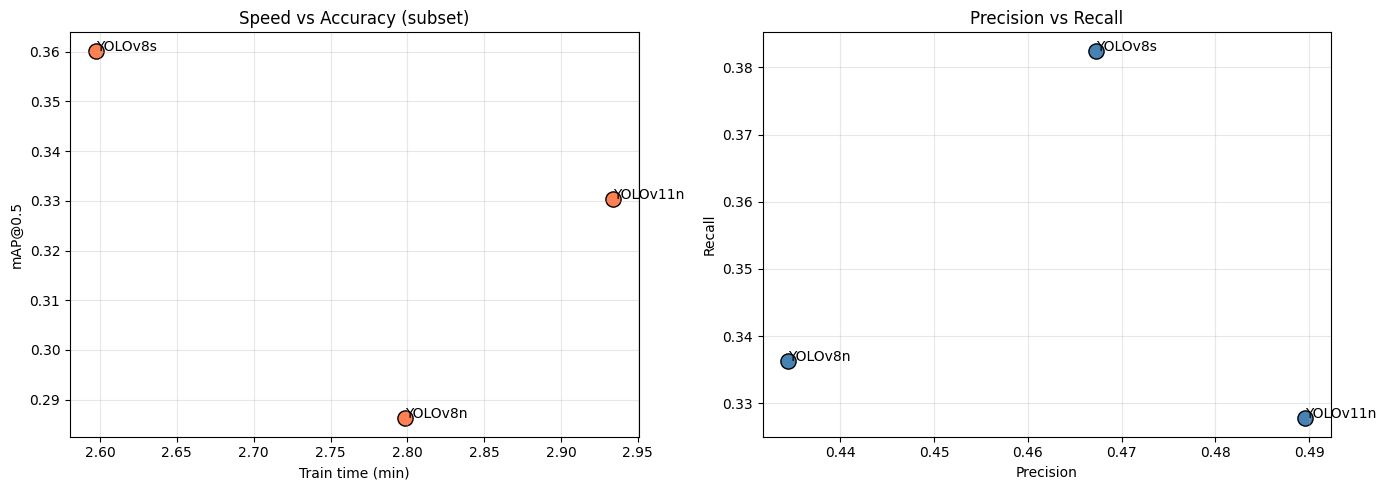


ℹ️ Sugerencia: si cuentas con GTs de tracking (IDs por frame), usa motmetrics para MOTA/MOTP/IDF1.
   Este notebook incluye una demo con conteos e ID switches aproximados (no métricas MOT completas).


In [ ]:
# === Visualizaciones y métricas comparativas (rápidas) ===

# Reutiliza df de Trabajo 1 (comparativa modelos)
try:
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    # Speed vs Accuracy (mAP50)
    ax[0].scatter(df['train_time_min'], df['map50'], s=120, c='coral', edgecolor='k')
    for i, name in enumerate(df.index):
        ax[0].annotate(name, (df['train_time_min'][i], df['map50'][i]))
    ax[0].set_xlabel('Train time (min)')
    ax[0].set_ylabel('mAP@0.5')
    ax[0].set_title('Speed vs Accuracy (subset)')
    ax[0].grid(alpha=0.3)

    # Precision vs Recall
    ax[1].scatter(df['precision'], df['recall'], s=120, c='steelblue', edgecolor='k')
    for i, name in enumerate(df.index):
        ax[1].annotate(name, (df['precision'][i], df['recall'][i]))
    ax[1].set_xlabel('Precision')
    ax[1].set_ylabel('Recall')
    ax[1].set_title('Precision vs Recall')
    ax[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
except Exception as e:
    print("⚠️ No hay df con métricas aún. Ejecuta Trabajo 1 primero.", e)

# Placeholder para métricas de tracking con motmetrics (si tienes GTs temporales)
print("\nℹ️ Sugerencia: si cuentas con GTs de tracking (IDs por frame), usa motmetrics para MOTA/MOTP/IDF1.")
print("   Este notebook incluye una demo con conteos e ID switches aproximados (no métricas MOT completas).")


In [ ]:
# === Comparación extendida: más épocas y más modelos (YOLOv8/YOLOv11) ===
# NOTA: YOLOv5n es opcional (requiere repo/paquete distinto). Dejamos comentario al final.

assert 'YAML_PATH' in globals(), 'YAML_PATH no definido. Ejecuta el Setup de Dataset primero.'
print('Usando YAML:', YAML_PATH)

# Modelos a comparar (Ultralytics >= 8.3, soporta YOLOv8 y YOLOv11)
MODELS_EXT = {
    'YOLOv8n': 'yolov8n.pt',
    'YOLOv8s': 'yolov8s.pt',
    'YOLOv8m': 'yolov8m.pt',
    'YOLOv11n': 'yolo11n.pt',
}

# Hiperparámetros más exigentes para ver diferencias
EPOCHS_EXT = 10
BATCH_EXT = 16
IMG_SIZE_EXT = 640
FRACTION_EXT = 0.75  # 75% del dataset para acelerar un poco sin perder señal

# Recolección de resultados
from time import time
import os
import psutil

extended_rows = []
per_model_details = {}

val_imgs_dir = None
for cand in [
    # intentos comunes
    Path(DATASET_ROOT) / 'Fruits-detection' / 'valid' / 'images',
    Path(DATASET_ROOT) / 'valid' / 'images',
    Path(DATASET_ROOT) / 'val' / 'images',
]:
    if cand.exists():
        val_imgs_dir = cand
        break

# Pequeño helper para tiempo de inferencia
def benchmark_inference(yolo_model, sample_paths: list[str], conf: float = 0.25) -> float:
    if not sample_paths:
        return float('nan')
    # warmup
    _ = yolo_model(sample_paths[0], conf=conf, verbose=False)
    t0 = time()
    for p in sample_paths:
        _ = yolo_model(p, conf=conf, verbose=False)
    t1 = time()
    return (t1 - t0) / len(sample_paths) * 1000.0

# Seleccionar 20 imágenes para medir inferencia si es posible
sample_paths = []
if val_imgs_dir is not None:
    cand_imgs = list(val_imgs_dir.glob('*.jpg')) + list(val_imgs_dir.glob('*.png'))
    sample_paths = [str(p) for p in cand_imgs[:20]]

for name, weights in MODELS_EXT.items():
    print(f"\n=== Entrenando {name} ({weights}) ===")
    model = YOLO(weights)

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    t0 = time()
    results = model.train(
        data=str(YAML_PATH),
        epochs=EPOCHS_EXT,
        imgsz=IMG_SIZE_EXT,
        batch=BATCH_EXT,
        fraction=FRACTION_EXT,
        device=device_choosen,
        name=f"exp_ext_{name.lower()}",
        project='runs/detect',
        verbose=True,
        save=True,
        plots=True,
        patience=7,
    )
    t1 = time()
    train_time_min = (t1 - t0) / 60

    # Validación
    metrics = model.val()

    # Tiempos de inferencia
    infer_ms = benchmark_inference(model, sample_paths, conf=0.3) if sample_paths else float('nan')

    # Tamaño de pesos (best.pt)
    weights_dir = Path(results.save_dir) / 'weights'
    best_path = weights_dir / 'best.pt'
    size_mb = os.path.getsize(best_path) / (1024 * 1024) if best_path.exists() else float('nan')

    # GPU memoria máxima
    gpu_mem_mb = float('nan')
    if torch.cuda.is_available():
        try:
            gpu_mem_mb = torch.cuda.max_memory_reserved() / (1024 * 1024)
        except Exception:
            pass

    row = {
        'model': name,
        'weights_dir': str(results.save_dir),
        'map50': float(metrics.box.map50),
        'map5095': float(metrics.box.map),
        'precision': float(metrics.box.mp),
        'recall': float(metrics.box.mr),
        'train_time_min': train_time_min,
        'infer_ms': infer_ms,
        'weights_mb': size_mb,
        'gpu_mem_max_mb': gpu_mem_mb,
    }
    extended_rows.append(row)

    # Guardar métricas por clase
    per_model_details[name] = {
        'class_map50': list(metrics.box.maps),
        'names': list(model.names.values()),
        'best_weights': str(best_path) if best_path.exists() else None,
    }

# DataFrame comparativo extendido
import pandas as pd

df_ext = pd.DataFrame(extended_rows).set_index('model').sort_values('map50', ascending=False)
print("\n📊 Comparativa extendida:")
display(df_ext[['map50','map5095','precision','recall','train_time_min','infer_ms','weights_mb','gpu_mem_max_mb']])

# Elegir mejor modelo por mAP@0.5
best_model_name = df_ext.index[0]
print(f"\n🥇 Mejor modelo por mAP@0.5: {best_model_name}")

# NOTA sobre YOLOv5n (opcional):
# Para entrenar YOLOv5n, se sugiere usar el repo oficial (pip install -q yolov5) y su CLI/train.py.
# Se deja fuera por simplicidad y para mantener un único flujo con Ultralytics v8/11 en este notebook.



Usando YAML: fruit_detection/data_fixed.yaml

=== Entrenando YOLOv8n (yolov8n.pt) ===
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fruit_detection/data_fixed.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=0.75, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp_ext_yolov8n, nbs=64, nms=False, opset=None, opt

In [ ]:
# === Visualización: detecciones con boxes en imágenes de validación ===

assert 'per_model_details' in globals() and 'df_ext' in globals(), 'Ejecuta la celda de Comparación extendida primero.'

# Tomar top-2 modelos por mAP@0.5 para comparar visualmente
top_models = list(df_ext.index[:2])
print('Modelos para visualización:', top_models)

# Construir modelos cargando sus best.pt
loaded = {}
for m in top_models:
    best_w = per_model_details[m]['best_weights']
    if best_w and Path(best_w).exists():
        loaded[m] = YOLO(best_w)
    else:
        # fallback a pesos base si no hay best
        print(f"⚠️ No se encontró best.pt para {m}, usando pesos base pre-entrenados")
        loaded[m] = YOLO(MODELS_EXT[m])

# Elegir 3 imágenes de validación
if val_imgs_dir is None:
    raise RuntimeError('No se encontraron imágenes de validación para visualizar.')

val_images_list = list(val_imgs_dir.glob('*.jpg')) + list(val_imgs_dir.glob('*.png'))
num_samples = min(3, len(val_images_list))
assert num_samples > 0, 'No hay imágenes de validación disponibles.'

sample_images = random.sample(val_images_list, num_samples)

for i, img_path in enumerate(sample_images, 1):
    print(f"\n=== Imagen {i}/{num_samples}: {img_path.name} ===")
    fig, axes = plt.subplots(1, len(top_models), figsize=(7*len(top_models), 7))
    if len(top_models) == 1:
        axes = [axes]

    for ax, (mname, mobj) in zip(axes, loaded.items()):
        res = mobj(str(img_path), conf=0.30, verbose=False)
        ann = res[0].plot()
        ax.imshow(cv2.cvtColor(ann, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(f"{mname}\n{len(res[0].boxes)} detecciones", fontsize=13, fontweight='bold')

    plt.suptitle(f'Comparación visual en validación: {img_path.name}', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()

print('\n✅ Visualización completada')



AssertionError: Ejecuta la celda de Comparación extendida primero.

In [ ]:
# === Gráficos: Speed vs Accuracy y mAP por clase ===

assert 'df_ext' in globals() and 'per_model_details' in globals(), 'Ejecuta la celda de Comparación extendida primero.'

# 1) Speed vs Accuracy (mAP@0.5 vs infer_ms)
plt.figure(figsize=(8,6))
plt.scatter(df_ext['infer_ms'], df_ext['map50'], s=140, c='coral', edgecolor='k')
for name in df_ext.index:
    plt.annotate(name, (df_ext.loc[name, 'infer_ms'], df_ext.loc[name, 'map50']))
plt.xlabel('Inference time (ms/img)')
plt.ylabel('mAP@0.5')
plt.title('Speed vs Accuracy (valid)')
plt.grid(alpha=0.3)
plt.show()

# 2) mAP por clase para el mejor modelo
best_name = df_ext.index[0]
class_map = per_model_details[best_name]['class_map50']
class_names = per_model_details[best_name]['names']

plt.figure(figsize=(10,5))
plt.bar(range(len(class_map)), class_map, color='steelblue', alpha=0.85)
plt.xticks(range(len(class_map)), class_names, rotation=30, ha='right')
plt.ylabel('mAP@0.5')
plt.title(f'mAP por clase - {best_name}')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print('\nℹ️ Los gráficos de losses por modelo están en runs/detect/<exp>/results.png (Ultralytics).')

